# Association Rules
## Submitted By: Anubhav Gupta
## Date: 02/06/2018


## Data Transformations in SQL

##### Identified the following features of the pos.tansact table in the database:
* C1 == SKU
* C2 == STORE
* C3 == REGISTER
* C4 == TRANNUM
* C6 == SALEDATE
* C7 == STYPE

##### Ran the following 1-time queries to Extract, Transform and Load into the schema. Notice that a unique STORE, REGISTER, TRANNUM and SALEDATE combination gives us 1 basket. Also, we pick only the 'Purchase' transactions.

```
CREATE TABLE agq3445_schema.trnsact_baskets AS
SELECT c1 AS sku, 
    NULLIF(c2, '')::int as store,
    to_timestamp(c6, 'YYYY-MM-DD') as datetran,
    c2||','||c3||','||c4||','||c6 as basketId 
        FROM pos.trnsact where c7='P';
```

##### Added the following indexes to make the queries run fast. We cluster the trnsact_baskets table by datetran field so that we can do fast range queries

```
CREATE INDEX idx_datetran
    ON agq3445_schema.trnsact_baskets USING btree
    (datetran ASC NULLS LAST)

ALTER TABLE agq3445_schema.trnsact_baskets
    CLUSTER ON idx_datetran;

CREATE INDEX idx_sku
    ON agq3445_schema.trnsact_baskets USING btree
    (sku ASC NULLS LAST);
    
CREATE INDEX idx_store
    ON agq3445_schema.trnsact_baskets USING btree
    (store ASC NULLS LAST);
```

##### Once the heavy lifting is done, we proceed to perform exploratory analysis on the new table

In [126]:
#Importing necessary libraries and connecting to the database
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from orangecontrib.associate.fpgrowth import *

host = "gallery.iems.northwestern.edu"
dbname = "iems308"
user = "agq3445"
password = "agq3445_pw"

conn_string = "host='%s' dbname='%s' user='%s' password='%s'" % (host, dbname, user, password)
print("Connecting to database\n%s" % (conn_string))
conn = pg.connect(conn_string)

def execute_query(query_str):
    return pd.read_sql(query_str, con = conn)

Connecting to database
host='gallery.iems.northwestern.edu' dbname='iems308' user='agq3445' password='agq3445_pw'


## Exploratory Analysis

In [127]:
#Finding the range of dates for which transactions are available
df = execute_query("select min(datetran), max(datetran) from agq3445_schema.trnsact_baskets")
df.head()

,min,max
0,2004-08-01 05:00:00+00:00,2005-08-27 05:00:00+00:00


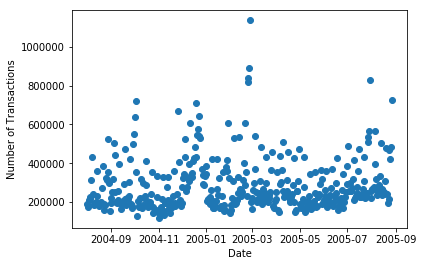

In [128]:
#For each date find and plot the number of transactions across all the stores
df = execute_query("select datetran, count(*) from agq3445_schema.trnsact_baskets group by datetran")

plt.figure()
dates = [pd.to_datetime(d) for d in df['datetran']]
plt.scatter(dates, df['count'])
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

#There doesn't seem to be a decipherable pattern in the counts, so we can do sampling according to the dates

In [129]:
#Finding total number of stores

df = execute_query("select count(distinct(store)) as stores from pos.strinfo")
print(df)

   stores
0     453


In [130]:
#Finding number of stores with transaction data

df = execute_query("select count(distinct(store)) from agq3445_schema.trnsact_baskets")
print(df)

#This means we have transaction data for 332/453 stores available

   count
0    332


In [131]:
#Finding number of stores with respective transaction counts

df = execute_query("select store, count(*) as num_transactions from agq3445_schema.trnsact_baskets group by store")
print(df.head())


   store  num_transactions
0   2102            529739
1   6604            414089
2    809            495486
3   7807            199568
4   5603            300918


In [132]:
#Finding number of skus defined for the dataset

df = execute_query("select count(distinct(sku)) as num_skus from pos.skuinfo")
print(df)

   num_skus
0   1048576


## Analysis

## Performing data subsetting by selecting transactions across all the stores for August 2015.

In [133]:
df = execute_query("SELECT basketid, sku FROM agq3445_schema.trnsact_baskets where datetran > '2005-08-01 00:00:00-05'")
df.head()

,basketid,sku
0,"8007,490,00300,2005-08-03",4399125 ...
1,"9304,431,00400,2005-08-10",4399125 ...
2,"202,370,05500,2005-08-05",4399133 ...
3,"307,40,08000,2005-08-05",4399133 ...
4,"404,330,04300,2005-08-23",4399133 ...


In [134]:
#Doing some exploration on the subset

num_baskets = len(df.basketid.unique())
unique_skus = len(df.sku.unique())
num_transactions = len(df.index)

print("Total number of transactions: ", num_transactions)
print("Total number of baskets: ", num_baskets)
print("Average basket size in the data subset: " + str(int(num_transactions/num_baskets)))
print("Total number of unique skus in the transaction data subset: ", unique_skus)

Total number of transactions:  8759373
Total number of baskets:  4347689
Average basket size in the data subset: 2
Total number of unique skus in the transaction data subset:  366116


In [135]:
#Reshaping each basket into list of SKUs
baskets_set = list(df['sku'].groupby(df['basketid']))
for i in range(len(baskets_set)):
    indexed_transaction = list(baskets_set[i][1:])[0]
    baskets_set[i] = [trans for trans in indexed_transaction]

In [136]:
from orangecontrib.associate.fpgrowth import *

itemsets = dict(frequent_itemsets(baskets_set, 600))
rules = list(association_rules(itemsets, 0.2))
rules_stats = rules_stats(rules, itemsets, num_baskets)
final_rules_stats = list(rules_stats)

## Post Processing

In [137]:
#Reading sku information from the table

skus = pd.read_sql("SELECT * from pos.skuinfo", con=conn)

In [146]:
import re
def get_sku_details(set_sku):
    str_sku = []
    str_dept = []
    str_brand = []
    for sku in set_sku:
        str_sku.append(re.sub("\D", "",sku))
        if not skus.loc[skus['sku'] == int(sku)].empty: 
            str_dept.append(str((skus.loc[skus['sku'] == int(sku)])['dept'].values[0]))
            str_brand.append(str((skus.loc[skus['sku'] == int(sku)])['brand'].values[0]).strip())
    return str_sku, str_dept, str_brand 

final_rules_stats_new = []
for i in range(len(final_rules_stats)): 
    str_skus_lhs, str_dept_lhs, str_brand_lhs = get_sku_details(final_rules_stats[i][0])
    str_skus_rhs, str_dept_rhs, str_brand_rhs = get_sku_details(final_rules_stats[i][1])
    final_rules_stats_new.append([str_skus_lhs, str_dept_lhs, str_brand_lhs, str_skus_rhs, str_dept_rhs, str_brand_rhs,
                            final_rules_stats[i][2], final_rules_stats[i][3], final_rules_stats[i][6]])


final_output = pd.DataFrame(final_rules_stats_new, columns = ["Antecedent_SKUs","Antecedent_Dept","Antecedent_Brand", "Consequent_SKUs","Consequent_Dept","Consequent_Brand", "Support", "Confidence","Lift"])
final_output = final_output.sort_values(by='Lift', ascending=False)     
final_output.to_csv("output.csv", header="true", index=False)
final_output
        

,Antecedent_SKUs,Antecedent_Dept,Antecedent_Brand,Consequent_SKUs,Consequent_Dept,Consequent_Brand,Support,Confidence,Lift
47,[341363],[4400],[SOUL MEN],[7641362],[],[],1111,0.872742,1519.587049
48,[7641362],[],[],[341363],[4400],[SOUL MEN],1111,0.444934,1519.587049
51,[959823],[2200],[LANCOME],[4980033],[2200],[LANCOME],611,0.969841,1233.275291
50,[869823],[2200],[LANCOME],[4980033],[2200],[LANCOME],661,0.953824,1212.907257
13,"[2716578, 3908011]","[800, 800]","[CLINIQUE, CLINIQUE]",[3988011],[800],[CLINIQUE],630,0.801527,1000.513607
11,"[3908011, 3988011]","[800, 800]","[CLINIQUE, CLINIQUE]",[2716578],[800],[CLINIQUE],630,0.782609,945.149783
8,[3908011],[800],[CLINIQUE],"[3998011, 2726578]","[800, 800]","[CLINIQUE, CLINIQUE]",974,0.290486,757.160288
9,"[3998011, 2726578]","[800, 800]","[CLINIQUE, CLINIQUE]",[3908011],[800],[CLINIQUE],974,0.583933,757.160288
12,"[2716578, 3988011]","[800, 800]","[CLINIQUE, CLINIQUE]",[3908011],[800],[CLINIQUE],630,0.576395,747.386596
4,"[3690654, 3898011]","[800, 800]","[CLINIQUE, CLINIQUE]",[3968011],[800],[CLINIQUE],825,0.825826,629.128064
